# Bike count forecasting using CNN-LSTM

In [1]:
import pandas as pd
import numpy as np
import os
import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing methods
from sklearn.preprocessing import StandardScaler

# accuracy measures and data spliting
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# deep learning libraries
from keras.models import Input, Model
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, SimpleRNN
from keras.layers import Conv1D, MaxPooling1D, Flatten
from keras import layers
from keras import losses
from keras import optimizers
from keras import metrics
from keras import callbacks
from keras import initializers

Using TensorFlow backend.


In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 15, 7

## 1. Data import and basic analysis

In [3]:
DATADIR = '../data/bike/'
MODELDIR = '../checkpoints/bike-sharing/cnnlstm/'

data_path = os.path.join(DATADIR, 'bike-sharing-processed.csv')
data = pd.read_csv(data_path)

In [4]:
data.set_index('date', inplace=True)
data.sort_index(inplace=True)
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,HurricaneSandy
date,,,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985,0
2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801,0
2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349,0
2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562,0
2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600,0


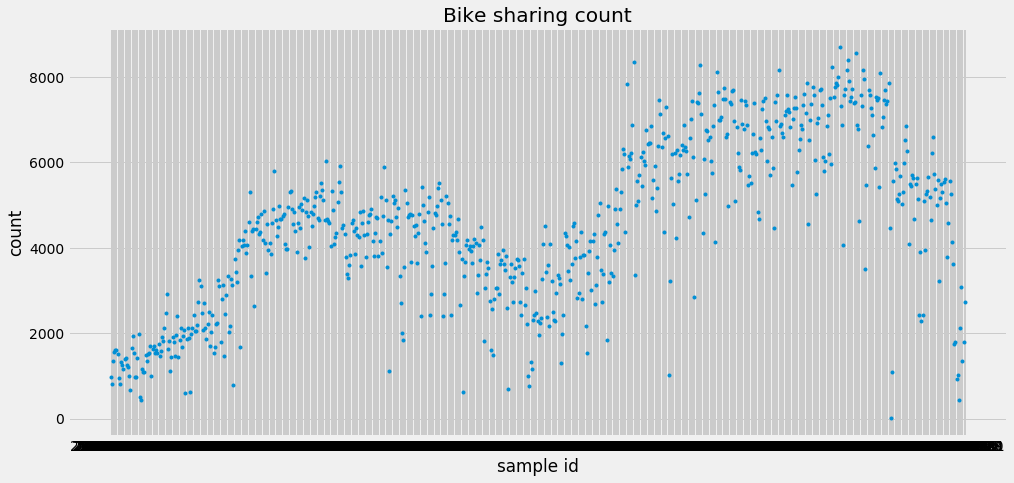

In [5]:
plt.plot(data.cnt, '.')
plt.title('Bike sharing count')
plt.xlabel('sample id')
plt.ylabel('count')
plt.show()

## 2. Data preparation

In [6]:
y = data[['cnt']].copy()
X = data.drop(columns=['cnt'], axis=1)

print(f'X and y shape:')
print(X.shape, y.shape)

# date selection
datelist = data.index.unique()

# two month data for testset
print(f'Test start date: {datelist[-61]}')

# Train test split : last 60 days for test set

X_train = X[X.index < datelist[-61]]
X_test = X[X.index >= datelist[-61]]

y_train = y[y.index < datelist[-61]]
y_test = y[y.index >= datelist[-61]]


print(f'Size of train and test set respectively:')
print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

X and y shape:
(731, 12) (731, 1)
Test start date: 2012-11-01
Size of train and test set respectively:
(670, 12) (61, 12) (670, 1) (61, 1)


In [7]:
timesteps = 1
features = X_train.shape[1]
xavier = initializers.glorot_normal()

X_train = np.reshape(X_train.values, (X_train.shape[0], timesteps, features))
X_test = np.reshape(X_test.values, (X_test.shape[0], timesteps, features))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((670, 1, 12), (61, 1, 12), (670, 1), (61, 1))

## 3. Model building

In [8]:
def model_evaluation(y_train, y_test, y_train_pred, y_test_pred):
    
    # MAE and NRMSE calculation
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_nrmse = train_rmse/np.std(y_train.values)

    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_nrmse = test_rmse/np.std(y_test.values)

    print(f'Training MAE: {np.round(train_mae, 3)}')
    print(f'Trainig NRMSE: {np.round(train_nrmse, 3)}')
    print()

    print(f'Test MAE: {np.round(test_mae)}')
    print(f'Test NRMSE: {np.round(test_nrmse)}')
    
    return

In [9]:
def model_training(X_train, X_test, y_train, model, batch=8, name='m'):
    start = time.time()
    loss = losses.mean_squared_error
    opt = optimizers.Adam()
    metric = [metrics.mean_absolute_error]
    model.compile(loss=loss, optimizer=opt, metrics=metric)

    callbacks_list = [callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.001)]

    history = model.fit(X_train, y_train, 
                        epochs=100, 
                        batch_size=batch, 
                        verbose=0,
                        shuffle=False,
                        callbacks=callbacks_list
                       )

    # save model weights and 
    if os.path.exists(MODELDIR):
        pass
    else:
        os.makedirs(MODELDIR)
    m_name = name + str('.h5')
    w_name = name + str('_w.h5')
    model.save(os.path.join(MODELDIR, m_name))
    model.save_weights(os.path.join(MODELDIR, w_name))

    # prediction
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    end = time.time()
    time_taken = np.round((end-start), 3)
    print(f'Time taken to complete the process: {time_taken} seconds')
    
    return y_train_pred, y_test_pred, history

### CNN-LSTM - v1

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Time taken to complete the process: 35.663 seconds
Training MAE: 704.436
Trainig NRMSE: 0.474

Test MAE: 1272.0
Test NRMSE: 1.0


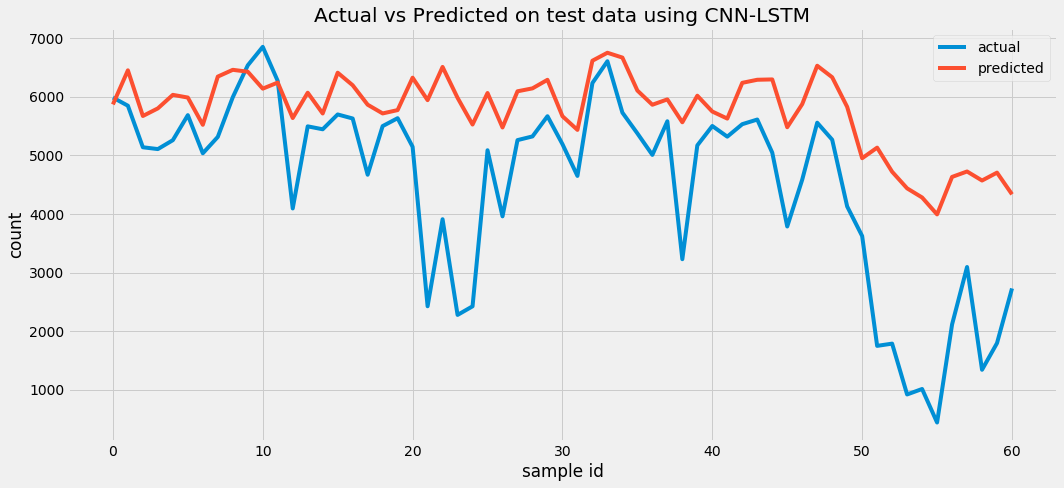

In [10]:
model = Sequential()
model.add(Conv1D(8, kernel_size=3, activation='relu', padding='same', strides=1, 
                 input_shape=(timesteps, features), kernel_initializer=xavier))

model.add(LSTM(8, kernel_initializer=xavier, activation='relu'))
model.add(Dense(8, activation='relu', kernel_initializer=xavier))
model.add(Dense(1, kernel_initializer=xavier))


y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=4, name='cnnlstm-v1')

model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.plot(y_test.values, label='actual')
plt.plot(y_test_pred, label='predicted')
plt.ylabel('count')
plt.xlabel('sample id')
plt.title('Actual vs Predicted on test data using CNN-LSTM')
plt.legend()
plt.tight_layout()
plt.show()

## CNN-LSTM - v2

Time taken to complete the process: 66.656 seconds
Training MAE: 4470.961
Trainig NRMSE: 2.486

Test MAE: 4500.0
Test NRMSE: 3.0


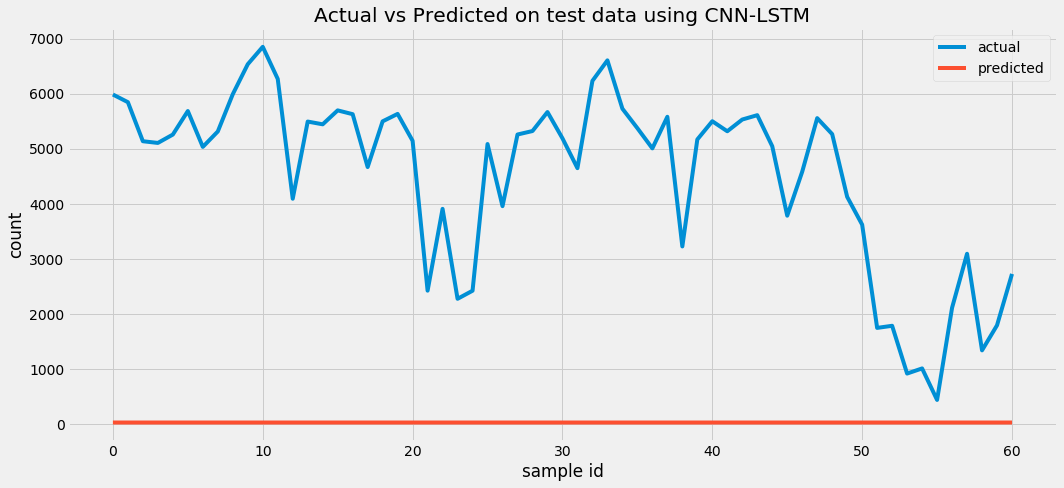

In [11]:
model = Sequential()
model.add(Conv1D(8, kernel_size=3, activation='relu', padding='same', strides=1, 
                 input_shape=(timesteps, features), kernel_initializer=xavier))

model.add(LSTM(8, kernel_initializer=xavier, activation='relu'))
model.add(Dense(1, kernel_initializer=xavier))


y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=2, name='cnnlstm-v2')

model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.plot(y_test.values, label='actual')
plt.plot(y_test_pred, label='predicted')
plt.ylabel('count')
plt.xlabel('sample id')
plt.title('Actual vs Predicted on test data using CNN-LSTM')
plt.legend()
plt.tight_layout()
plt.show()

## CNN-LSTM - v3 (final model)

Time taken to complete the process: 105.375 seconds
Training MAE: 681.263
Trainig NRMSE: 0.467

Test MAE: 1220.0
Test NRMSE: 1.0


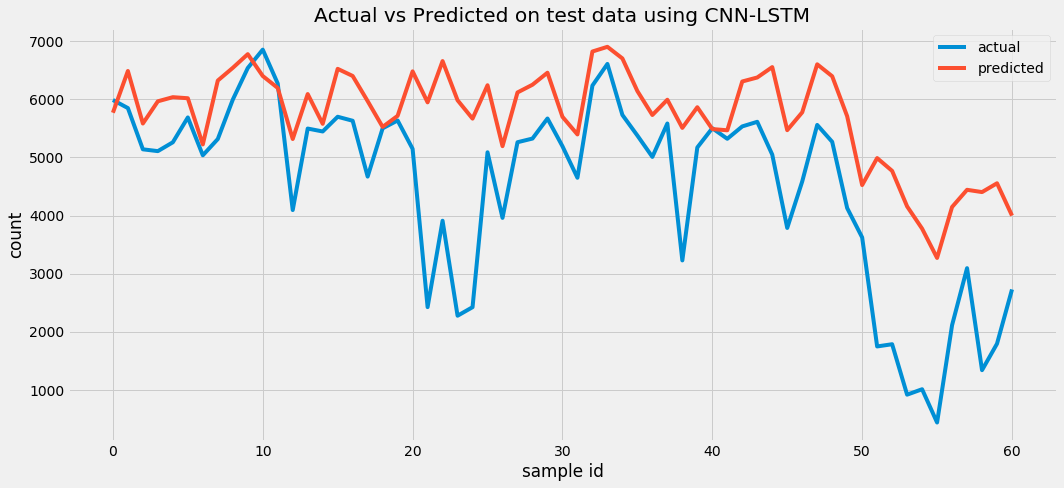

In [13]:
model = Sequential()
model.add(Conv1D(8, kernel_size=3, activation='relu', padding='same', strides=1, 
                 input_shape=(timesteps, features), kernel_initializer=xavier))
model.add(Conv1D(8, kernel_size=3, activation='relu', padding='same', strides=1, 
                 input_shape=(timesteps, features), kernel_initializer=xavier))

model.add(LSTM(8, kernel_initializer=xavier, activation='relu', return_sequences=True))
model.add(LSTM(8, kernel_initializer=xavier, activation='relu'))
model.add(Dense(1, kernel_initializer=xavier))


y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=2, name='cnnlstm-v3')

model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.plot(y_test.values, label='actual')
plt.plot(y_test_pred, label='predicted')
plt.ylabel('count')
plt.xlabel('sample id')
plt.title('Actual vs Predicted on test data using CNN-LSTM')
plt.legend()
plt.tight_layout()
plt.show()

## CNN-LSTM - v4

Time taken to complete the process: 107.383 seconds
Training MAE: 675.447
Trainig NRMSE: 0.47

Test MAE: 1317.0
Test NRMSE: 1.0


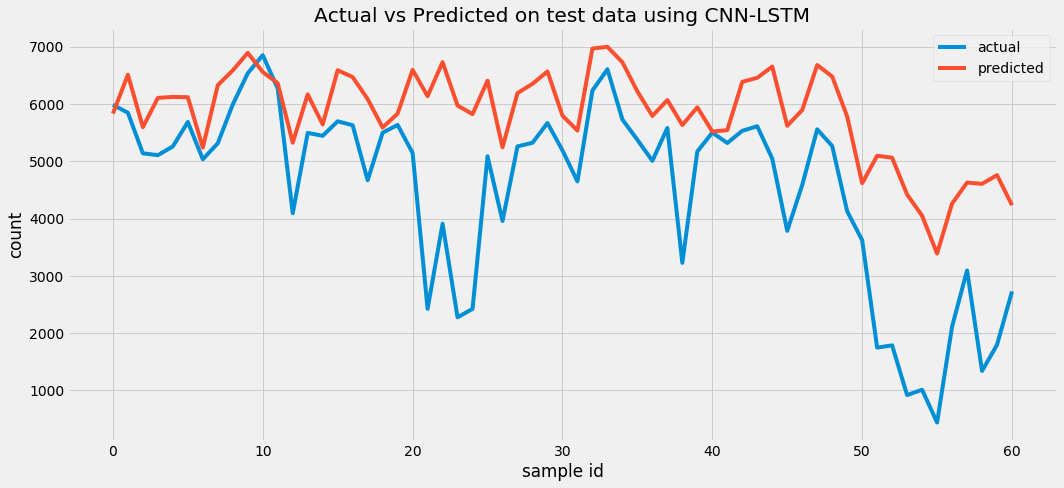

In [14]:
model = Sequential()
model.add(Conv1D(8, kernel_size=3, activation='relu', padding='same', strides=1, 
                 input_shape=(timesteps, features), kernel_initializer=xavier))
model.add(Conv1D(16, kernel_size=3, activation='relu', padding='same', strides=1, 
                 input_shape=(timesteps, features), kernel_initializer=xavier))

model.add(LSTM(16, kernel_initializer=xavier, activation='relu', return_sequences=True))
model.add(LSTM(8, kernel_initializer=xavier, activation='relu'))
model.add(Dense(1, kernel_initializer=xavier))


y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=2, name='cnnlstm-v4')

model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.plot(y_test.values, label='actual')
plt.plot(y_test_pred, label='predicted')
plt.ylabel('count')
plt.xlabel('sample id')
plt.title('Actual vs Predicted on test data using CNN-LSTM')
plt.legend()
plt.tight_layout()
plt.show()

## CNN-LSTM - v5

Time taken to complete the process: 110.898 seconds
Training MAE: 759.327
Trainig NRMSE: 0.526

Test MAE: 1370.0
Test NRMSE: 1.0


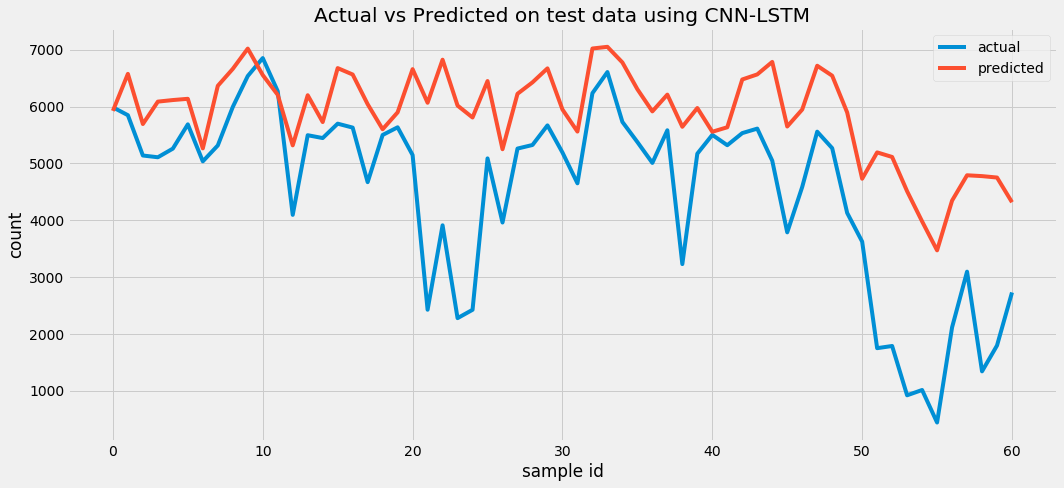

In [15]:
model = Sequential()
model.add(Conv1D(8, kernel_size=3, activation='relu', padding='same', strides=1, 
                 input_shape=(timesteps, features), kernel_initializer=xavier))
model.add(Conv1D(16, kernel_size=3, activation='relu', padding='same', strides=1, 
                 input_shape=(timesteps, features), kernel_initializer=xavier))

model.add(LSTM(16, kernel_initializer=xavier, activation='relu', return_sequences=True))
model.add(LSTM(8, kernel_initializer=xavier, activation='relu'))
model.add(Dense(8, kernel_initializer=xavier, activation='relu'))
model.add(Dense(1, kernel_initializer=xavier))


y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=2, name='cnnlstm-v5')

model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.plot(y_test.values, label='actual')
plt.plot(y_test_pred, label='predicted')
plt.ylabel('count')
plt.xlabel('sample id')
plt.title('Actual vs Predicted on test data using CNN-LSTM')
plt.legend()
plt.tight_layout()
plt.show()

### CNN-LSTM - v6

Time taken to complete the process: 106.158 seconds
Training MAE: 733.862
Trainig NRMSE: 0.51

Test MAE: 1362.0
Test NRMSE: 1.0


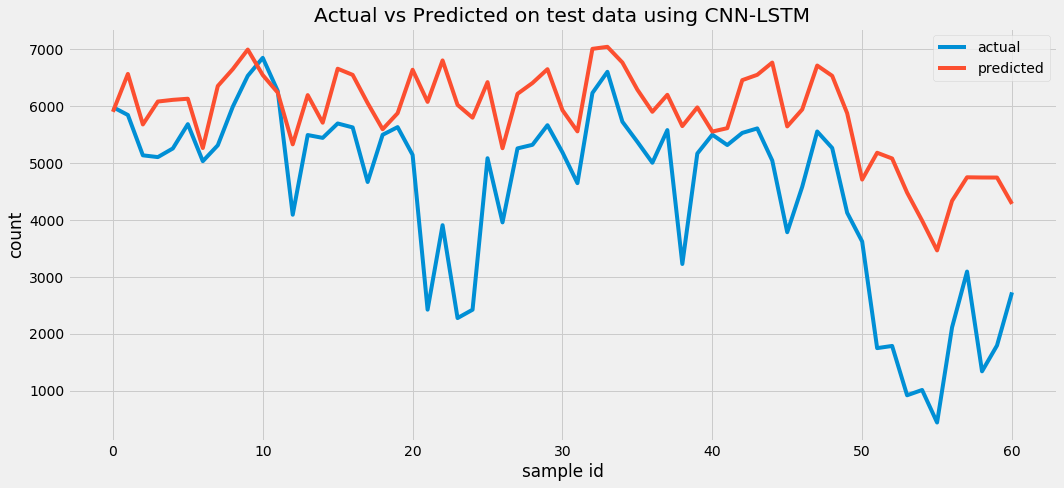

In [16]:
model = Sequential()
model.add(Conv1D(16, kernel_size=3, activation='relu', padding='same', strides=1, 
                 input_shape=(timesteps, features), kernel_initializer=xavier))
model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same', strides=1, 
                 input_shape=(timesteps, features), kernel_initializer=xavier))

model.add(LSTM(32, kernel_initializer=xavier, activation='relu', return_sequences=True))
model.add(LSTM(8, kernel_initializer=xavier, activation='relu'))
model.add(Dense(1, kernel_initializer=xavier))


y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=2, name='cnnlstm-v6')

model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.plot(y_test.values, label='actual')
plt.plot(y_test_pred, label='predicted')
plt.ylabel('count')
plt.xlabel('sample id')
plt.title('Actual vs Predicted on test data using CNN-LSTM')
plt.legend()
plt.tight_layout()
plt.show()